In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2, random, copy, tqdm
from PIL import Image
from sklearn.model_selection import train_test_split

randomseed = 2022
random.seed(randomseed)
np.random.seed(randomseed)
torch.manual_seed(randomseed)
torch.cuda.manual_seed(randomseed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [27]:
import torchvision.models as models

In [28]:
# 1. load data
DATA_DIR = 'D:/Documents/GitHub/DeepNotebook1/FCComputerVision/DATASET/Classification/train'
data_classes = ['Covid', 'Normal', 'Viral Pneumonia']
def load_images(DATA_DIR, sub_dir):
    image_format = ['jpeg', 'jpg', 'png']
    images = []
    images_dir = os.path.join(DATA_DIR, sub_dir)
    for file_path in os.listdir(images_dir):
        if file_path.split('.')[-1] in image_format:
            images.append(os.path.join(images_dir, file_path))

    return images

In [29]:
normal_list = load_images(DATA_DIR, 'Normal')
covid_list = load_images(DATA_DIR, 'Covid')
viral_list = load_images(DATA_DIR, 'Viral Pneumonia')

In [30]:
# 2. 학습 데이터셋 클래스 정의
class ChestDataset(Dataset):
    def __init__(self, data_dir, transforms=None):
        self.data_dir = data_dir
        self.transforms = transforms
        self.images = []
        normal_image_path = load_images(data_dir, 'Normal')
        covid_image_path = load_images(data_dir, 'Covid')
        viral_image_path = load_images(data_dir, 'Viral Pneumonia')
        self.images = normal_image_path + covid_image_path + viral_image_path
        
        
    def __getitem__(self, index):
        image_file = os.path.join(self.data_dir, self.images[index])
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        class_dict = {'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
        label = class_dict[self.images[index].split('\\')[-2]]
        if self.transforms:
            image = self.transforms(image)
            label = torch.tensor(label)
        return {'image': image, 'label': label}

    def __len__(self):
        return len(self.images)

In [31]:
dset = ChestDataset(DATA_DIR)

In [32]:
print(dset[200]['image'].shape, dset[200]['label'])

(1024, 1336, 3) 2


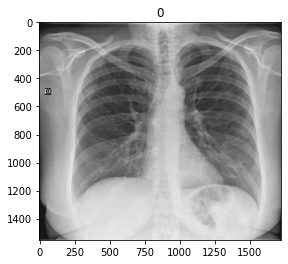

In [33]:
index = random.randint(0, len(dset))
plt.title(dset[index]['label'])
plt.imshow(dset[index]['image'])

In [34]:
dset.images[100]

'D:/Documents/GitHub/DeepNotebook1/FCComputerVision/DATASET/Classification/train\\Covid\\051.jpeg'

In [35]:
# 3. 배열을 연산가능한 텐서로 변환
transformers = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [36]:
train_dset = ChestDataset(DATA_DIR, transformers)

In [37]:
index = random.randint(0, len(train_dset))
image = train_dset[index]['image']
label = train_dset[index]['label']

In [38]:
image.shape, data_classes[label]

(torch.Size([3, 224, 224]), 'Covid')

In [39]:
# 5. 데이터로더 구현하기
batchsize = 8
def get_data_loader(train_data_dir, val_data_dir):
    data_loaders = {}
    train_dset = ChestDataset(train_data_dir, transformers)
    val_dset = ChestDataset(val_data_dir, transformers)
    train_loader = DataLoader(train_dset, batch_size=batchsize, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_dset, batch_size=batchsize, shuffle=True, drop_last=True) 
    # drop_last: 마지막 배치에서 남은 이미지를 사용하지 않도록 하는 옵션
    data_loaders['train'] = train_loader
    data_loaders['val'] = val_loader
    return data_loaders

In [40]:
train_data_dir = 'D:/Documents/GitHub/DeepNotebook1/FCComputerVision/DATASET/Classification/train'
val_data_dir = 'D:/Documents/GitHub/DeepNotebook1/FCComputerVision/DATASET/Classification/test'
data_loaders = get_data_loader(train_data_dir, val_data_dir)

In [41]:
for i, d in enumerate(data_loaders["train"]):
    if i == 0:
        break

In [42]:
# 6. 모델 구현하기
from torchvision.models import resnet18, ResNet18_Weights
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [43]:
from torchsummary import summary
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [44]:
# 7. 손실함수, 옵티마이저 구현하기
criterion = nn.CrossEntropyLoss(reduction='mean')
# reduction = 'mean', 'none', 'sum': 정답과 예측 값의 cross entropy 결과 값 평균, 모든 pixel의 값, 합의 값을 return.
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [45]:
# 모델 검증을 위한 Accuracy 계산하기
@torch.no_grad()
def get_accuracy(target, model, batch_size):
    total_correct = 0
    total_samples = 0
    for i in range(0, len(target), batch_size):
        batch_target = target[i:i+batch_size]
        batch_output = model(batch_target['image'].cuda())
        _, predicted = torch.max(batch_output.data, 1)
        total_correct += (predicted == batch_target['label'].cuda()).sum().item()
        total_samples += batch_target['image'].size(0)
    return total_correct / total_samples

In [46]:
# 학습 함수 구현하기
def train_one_epoch(model, data_loader, optimizer, loss_func, device):
    losses = {}
    accuracies = {}
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        total_loss = 0.0
        total_correct = 0
        total_samples = 0

        for index, minibatch in enumerate(data_loader[phase]):
            inputs = minibatch['image'].to(device)
            labels = minibatch['label'].to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                pred = model(inputs)
                loss = loss_func(pred, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                total_loss += loss.item()
                _, predicted = torch.max(pred.data, 1)
                total_correct += (predicted == labels).sum().item()
                total_samples += inputs.size(0)
        losses[phase] = total_loss / len(data_loader[phase])
        accuracies[phase] = total_correct / total_samples
    return losses, accuracies



In [47]:
# 9. 모델 저장하기
def save_best_model(model_state, model_name, save_dir):
    os.makedirs(save_dir, exist_ok=True)
    torch.save(model_state, f'{save_dir}/{model_name}.pth')

In [49]:

num_epochs = 10
best_acc = 0.0
train_loss, train_acc = [], []
val_loss, val_acc = [], []
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for epoch in tqdm.trange(num_epochs):
    losses_, accuracies_ = train_one_epoch(model, data_loaders, optimizer, criterion, device)
    train_loss.append(losses_['train'])
    train_acc.append(accuracies_['train'])
    val_loss.append(losses_['val'])
    val_acc.append(accuracies_['val'])
    if accuracies_['val'] > best_acc:
        best_acc = accuracies_['val']
        save_best_model(model.state_dict(), 'best_model', './models')
    print(f'Epoch: {epoch+1:02}/{num_epochs:02} Loss: {losses_["train"]:.4f}/{losses_["val"]:.4f} Acc: {accuracies_["train"]:.4f}/{accuracies_["val"]:.4f}')

 10%|█         | 1/10 [00:19<02:59, 19.96s/it]

Epoch: 01/10 Loss: 1.4789/2.4881 Acc: 0.7702/0.7031


 20%|██        | 2/10 [00:39<02:38, 19.83s/it]

Epoch: 02/10 Loss: 0.4200/0.2868 Acc: 0.8508/0.8906


 30%|███       | 3/10 [00:59<02:18, 19.74s/it]

Epoch: 03/10 Loss: 0.1154/0.2258 Acc: 0.9556/0.9062


 40%|████      | 4/10 [01:19<01:58, 19.75s/it]

Epoch: 04/10 Loss: 0.2487/0.1423 Acc: 0.9153/0.9375


 50%|█████     | 5/10 [01:38<01:37, 19.45s/it]

Epoch: 05/10 Loss: 0.1637/0.2006 Acc: 0.9435/0.9375


 60%|██████    | 6/10 [02:01<01:23, 20.82s/it]

Epoch: 06/10 Loss: 0.1939/0.1979 Acc: 0.9435/0.9062


 70%|███████   | 7/10 [02:23<01:04, 21.35s/it]

Epoch: 07/10 Loss: 0.1063/0.7469 Acc: 0.9637/0.8438


 80%|████████  | 8/10 [02:43<00:41, 20.76s/it]

Epoch: 08/10 Loss: 0.1400/0.4699 Acc: 0.9435/0.8438


 90%|█████████ | 9/10 [03:01<00:19, 19.82s/it]

Epoch: 09/10 Loss: 0.0619/0.0755 Acc: 0.9798/0.9844


100%|██████████| 10/10 [03:19<00:00, 19.90s/it]

Epoch: 10/10 Loss: 0.0263/0.1285 Acc: 0.9960/0.9375


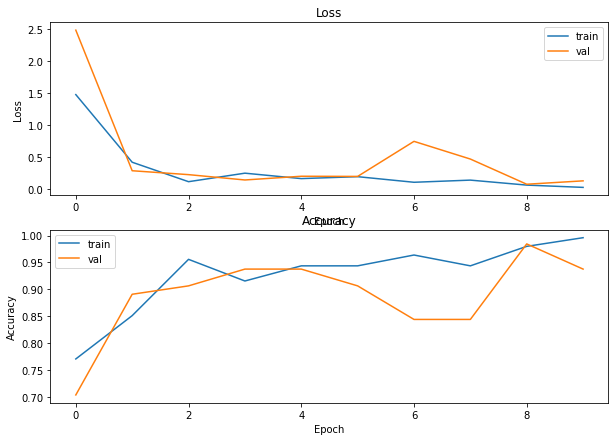

In [50]:
# 10. 결과 확인하기
plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
